# Introduction

The Transformer model, originally proposed by Vaswani et al. in 2017, has revolutionized the field of natural language processing. It introduced a novel approach to sequence-to-sequence tasks, replacing traditional recurrent neural networks (RNNs) with self-attention mechanisms. This shift allowed the model to process input sequences in parallel and better capture long-range dependencies, leading to improved performance in a variety of language tasks.

In this work, I implemented the Transformer model, specifically its variant known as GPT-2, for character-level language modeling. This report details the components and workings of our implementation, aiming to shed light on how this powerful model functions.

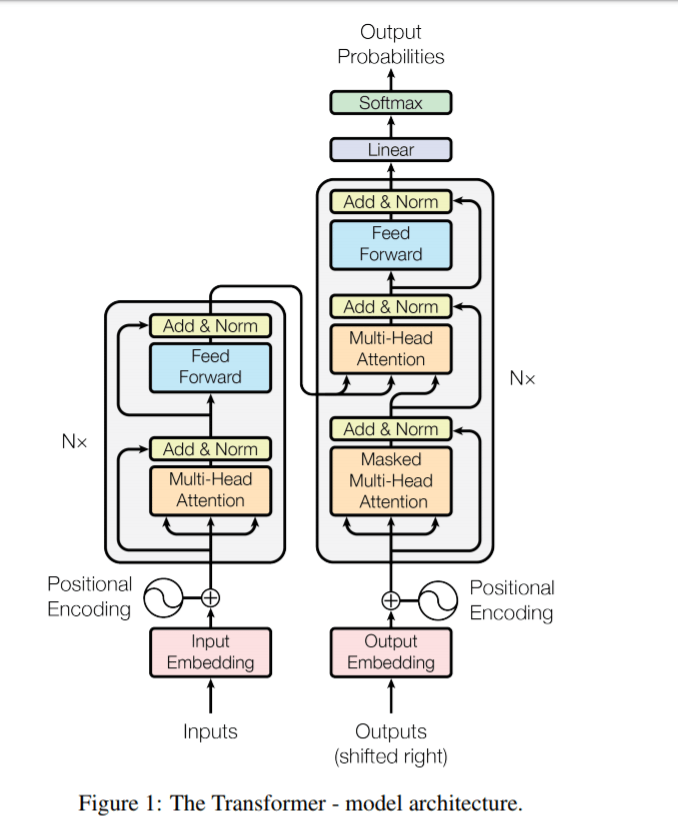

## Importing necessary dependencies

In [ ]:
import os
import time
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from dataset_utils import clean_and_train_test_split, CharacterDataset, ContinuousDataLoader
from model_helpers import ModelConfig, display_samples, create_tokens, evaluate

In [2]:
seed = 10110609
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
device = 'cpu'
work_dir = 'out'
top_k = None

## Constructing the train/test dataset

In [5]:
train_dataset, test_dataset, alphabet = clean_and_train_test_split()
vocab_size = train_dataset.get_vocab_size() # 26 letter plus end token (".")
block_size = train_dataset.get_output_length() # max lenght word + 1
print(f"{vocab_size=}, {block_size=}")

word size in the data: 91073
word with the maximum length: 16
number of characters in the alphabet: 26
alphabet:  abcdefghijklmnopqrstuvwxyz
train set size: 90073, test set size: 1000
vocab_size=27, block_size=17


# Transformer

## Model Configurations

In [6]:
n_layer = 4
n_head = 4
n_embd = 64
n_embd2 = 64
    
config = ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)

**NewGELU Class**

The `NewGELU` class implements the Gaussian Error Linear Units (GELU) activation function, a popular choice in Transformer models. The GELU activation function tends to outperform traditional activation functions, like ReLU, in deep learning models by enabling faster and more accurate learning.

In [ ]:
# This class is used for applying the GELU activation function (https://arxiv.org/abs/1606.08415)
class NewGELU(nn.Module):
    """Applies the Gaussian Error Linear Unit (GELU) function element-wise:
       0.5 * x * (1 + tanh(sqrt(2 / pi) * (x + 0.044715 * x^3)))
       Can be used as a drop-in replacement for ReLU.
    """

    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


**CausalSelfAttention Class**

The `CausalSelfAttention` class implements the self-attention mechanism, which is the core of the Transformer model. It allows the model to weigh the importance of each input when predicting an output, which significantly improves the handling of long-range dependencies in the data. 

To maintain the temporal sequence of the data, this class implements causal (or masked) self-attention. This means the attention mechanism is designed such that each output position can only attend to earlier positions in the sequence, preserving the causal structure of the input.

In [ ]:
# This class implements causal (unidirectional) self-attention mechanism
class CausalSelfAttention(nn.Module):
    """Performs multi-head self-attention, then applies an output linear transformation.
       Causal (unidirectional) self-attention uses masked attention mechanism.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)  # Linear layer to create queries, keys and values
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)  # Output linear transformation
        # We register a lower triangular matrix used for causal masking
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head  # Number of attention heads
        self.n_embd = config.n_embd  # Embedding dimension

    def forward(self, x):
        B, T, C = x.size()  # Batch size, sequence length, feature number

        # Splitting the last dimension of the input tensor into queries, keys and values
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        
        # Reshape and transpose the dimensions for q, k and v
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) 
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) 
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) 

        # Compute the attention scores
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))  # Apply the mask
        att = F.softmax(att, dim=-1)  # Compute the attention probabilities
        y = att @ v  # Compute the weighted sum of values
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reshape y

        y = self.c_proj(y)  # Apply the output linear transformation
        return y

**Block Class**

The `Block` class forms the building block of the Transformer model. Each block in the Transformer model comprises two parts: a self-attention layer (`CausalSelfAttention`) and a position-wise feed-forward neural network (`mlpf`). This structure allows the model to capture both the contextual relevance of each input (via self-attention) and complex relationships in the data (via the feed-forward network).

In [ ]:
# The Transformer block
class Block(nn.Module):
    """An implementation of a Transformer block. It applies, in sequence, self-attention, layer normalization,
       a feed-forward neural network, and another layer normalization.
    """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)  # Layer normalization before self-attention
        self.attn = CausalSelfAttention(config)  # Self-attention mechanism
        self.ln_2 = nn.LayerNorm(config.n_embd)  # Layer normalization before MLP
        # Multi-layer perceptron with GELU activation
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x)))  # An MLP as a function

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))  # Self-attention with residual connection
        x = x + self.mlpf(self.ln_2(x))  # MLP with residual connection
        return x

**Transformer Class**

Finally, the `Transformer` class ties all these components together into a complete Transformer model. The model accepts an input sequence of tokens and returns a sequence of output logits. The forward propagation involves passing the input through an embedding layer, several Transformer blocks, and a linear output layer to produce the logits.

The `forward` method also calculates the loss if target outputs are provided, making it useful for both training and inference. This Transformer model specifically is the GPT-2 variant, where the input sequences are processed from left to right, making it particularly well-suited for tasks like language modeling. 

This implementation showcases the flexibility and power of the Transformer model, allowing for efficient character-level language modeling that captures both short and long-term dependencies in the input data.

In [ ]:
# The main Transformer class
class Transformer(nn.Module):
    """The main Transformer model, implementing embedding, positional encoding, Transformer blocks,
       layer normalization and a final linear layer for language modelling.
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        # Transformer parts
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),  # Token embedding
            wpe = nn.Embedding(config.block_size, config.n_embd),  # Positional encoding
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),  # The Transformer blocks
            ln_f = nn.LayerNorm(config.n_embd),  # Final layer normalization
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # The final linear layer

        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))  # Print out the number of parameters

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)  # Position encoding

        tok_emb = self.transformer.wte(idx)  # Token embedding
        pos_emb = self.transformer.wpe(pos)  # Positional encoding
        x = tok_emb + pos_emb  # Add token and positional embeddings
        for block in self.transformer.h:
            x = block(x)  # Apply each Transformer block
        x = self.transformer.ln_f(x)  # Apply final layer normalization
        logits = self.lm_head(x)  # Compute final output logits
        
        # If targets are provided, compute the loss function (useful for training)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss


## Initializing the Model

In [8]:
model = Transformer(config)
# now using more advanced optimizer rather than SGD`
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)
batch_loader = ContinuousDataLoader(train_dataset, batch_size=32, pin_memory=True, num_workers=4)
writer = SummaryWriter(log_dir=work_dir)

print(f"model #params: {sum(p.numel() for p in model.parameters())}")

number of parameters: 0.20M
model #params: 204608


## Defining Train configurations

In [9]:
max_steps = 50000
best_loss = None
step = 0

In [10]:
train_losses, test_losses = [], []

## Parameter Optimization

In [ ]:
while True:

    t0 = time.time()

    # batch loading
    batch = batch_loader.get_next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    # fitting into model
    logits, loss = model(X, Y)

    # parameter optimization
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Ensure that all CUDA operations are complete before measuring the time.
    if device.startswith('cuda'):
        torch.cuda.synchronize()
    t1 = time.time()

    # logging and tracking stats
    if step % 10 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    # evaluate the model
    if step > 0 and step % 500 == 0:
        train_lossi = evaluate(model, train_dataset, device, batch_size=100, max_batches=10)
        test_lossi  = evaluate(model, test_dataset, device, batch_size=100, max_batches=10)
        train_losses.append(train_lossi)
        test_losses.append(test_lossi)
        writer.add_scalar("Loss/train", train_lossi, step)
        writer.add_scalar("Loss/test", test_lossi, step)
        writer.flush()
        print(f"step {step} train loss: {train_lossi} test loss: {test_lossi}")
        # save the model to disk if it has improved
        if best_loss is None or test_lossi < best_loss:
            out_path = os.path.join(work_dir, "model.pt")
            print(f"test loss {test_lossi} is the best so far, saving model to {out_path}")
            torch.save(model.state_dict(), out_path)
            best_loss = test_lossi

    # sample from the model
    if step > 0 and step % 200 == 0:
        display_samples(device, train_dataset, model, quantity=10)ContinuousDataLoader

    step += 1
    # termination conditions
    if max_steps >= 0 and step >= max_steps:
        break

**In order to save place, real training logs has been deleted and replaced with the snapshot. The lowest loss that I have been able to get was `2.0695`. This number outperforms all the previous implemented architecture.**

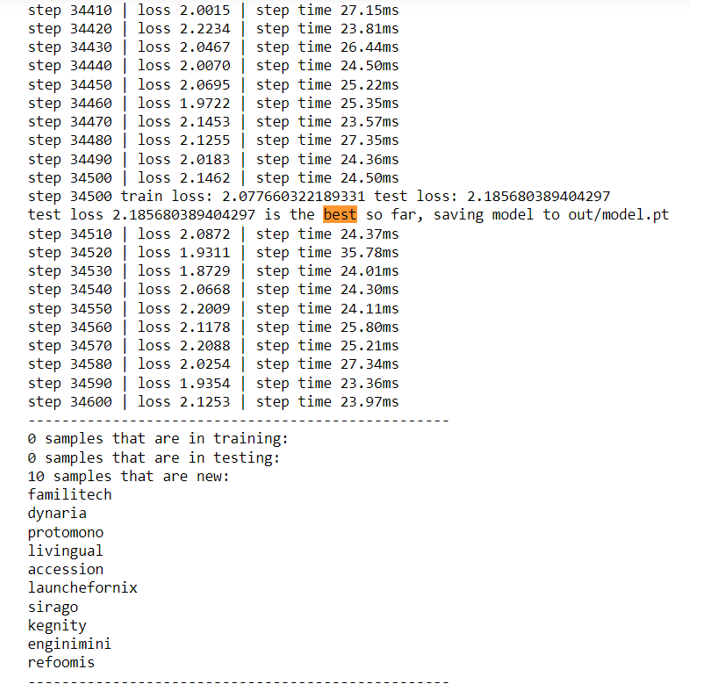

In [ ]:
# sharefly
# onbotech
# lunnyou
# skillpie
# livegain

## Train and Test Loss 

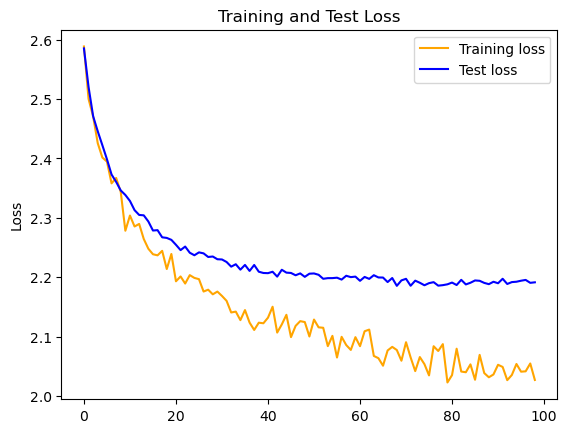

In [15]:
steps = [i for i in range(len(train_losses))]
plt.plot(steps, train_losses, 'orange', label='Training loss')
plt.plot(steps, test_losses, 'blue', label='Test loss') 
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()